## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. These will be uploaded for you the week of Oct 24th, at which point we'll update this notebook with a link. 

**Update:** This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains many additional slides and masks you can use. Note that while the starter code below downloads one slide from a Google Cloud URL (we have hosted this online for you for convenience), you will need to find a way to work with the other slides yourself for practice. You do not need to use them all! Just a few. You can either host the slides you'll use on Cloud storage using any provider, or you can download from Google Drive in your notebook (this may be slow).

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, on any topic of interest to you.

In [2]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!sudo apt-get install openslide-tools
!pip install openslide-python

'apt-get' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
os.chdir("C:\\Users\\aroni\\Documents\\adl-f22\\adl-fall2022-prj")
from PIL import Image
from skimage.color import rgb2gray

In [18]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.
slide_name = 'tumor_091.tif' # only this file is available
tumor_mask_name = 'tumor_091_mask.tif' # only this file is available

slide_path = os.path.join('./data',slide_name) # only this file is available
tumor_mask_path = os.path.join('./data', tumor_mask_name) # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_name
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_name

# Download the whole slide image
if not os.path.exists(slide_path):
  os.chdir("./data/")
  !curl -O $slide_url
  os.chdir("..")

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  os.chdir("./data/")
  !curl -O $mask_url
  os.chdir("..")

^C


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 14.6M    0  2709    0     0   1339      0  3:11:23  0:00:02  3:11:21  1340
  0 14.6M    0 57500    0     0  16758      0  0:15:17  0:00:03  0:15:14 16763
  0 14.6M    0 64344    0     0  16995      0  0:15:04  0:00:03  0:15:01 16990
  0 14.6M    0 65535    0     0  13630      0  0:18:48  0:00:04  0:18:44 13630
  1 14.6M    1  213k    0     0  39097      0  0:06:33  0:00:05  0:06:28 50811
  2 14.6M    2  380k    0     0  59089      0  0:04:20  0:00:06  0:04:14 84601
  3 14.6M    3  513k    0     0  69262      0  0:03:41  0:00:07  0:03:34  109k
  3 14.6M    3  594k    0     0  70283      0  0:03:38  0:00:08  0:03:30  109k
  4 14.6M    4  744k    0     0  79042      0  0:03

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  521M    0   325    0     0    312      0  20d 06h  0:00:01  20d 06h   312
  0  521M    0  250k    0     0   109k      0  1:21:09  0:00:02  1:21:07  109k
  0  521M    0  522k    0     0   174k      0  0:50:59  0:00:02  0:50:57  174k
  0  521M    0  805k    0     0   201k      0  0:44:04  0:00:03  0:44:01  201k
  0  521M    0 1044k    0     0   209k      0  0:42:31  0:00:04  0:42:27  209k
  0  521M    0 1271k    0     0   205k      0  0:43:17  0:00:06  0:43:11  246k
  0  521M    0 1508k    0     0   207k      0  0:42:53  0:00:07  0:42:46  252k
  0  521M    0 1764k    0     0   213k      0  0:41:38  0:00:08  0:41:30  235k
  0  521M    0 1917k    0     0   198k      0  0:44:49  0:00:09  0:44:40  196k
  0  521M    0 1926k    0     0   180k      0  0:49

In [20]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                         slide.level_dimensions[0][0], 
                                                         slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(min(len(slide.level_dimensions),8)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from ./data\tumor_091.tif with width: 61440, height: 53760
Read tumor mask from ./data\tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [21]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

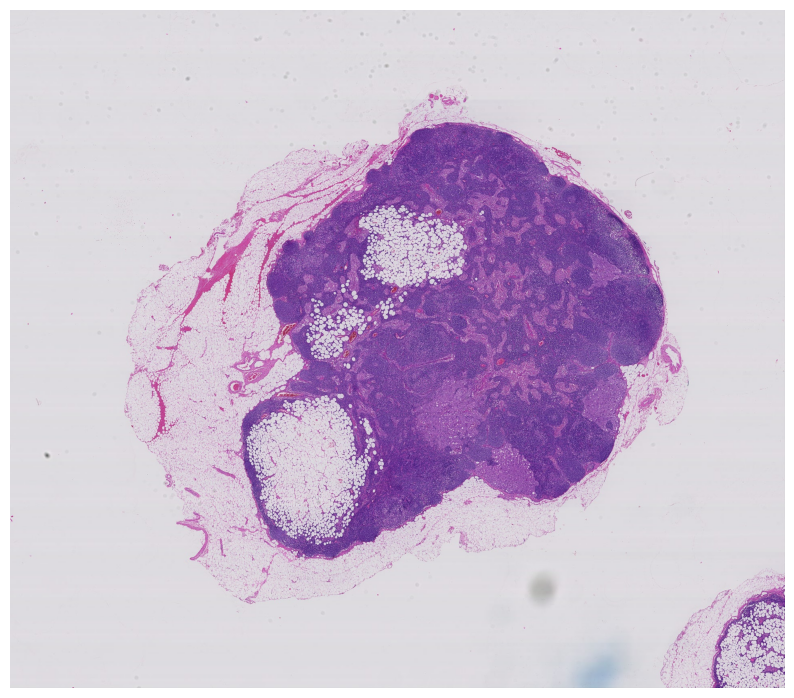

In [28]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.axis('off')
plt.savefig("./figs/Cell.png", bbox_inches='tight')

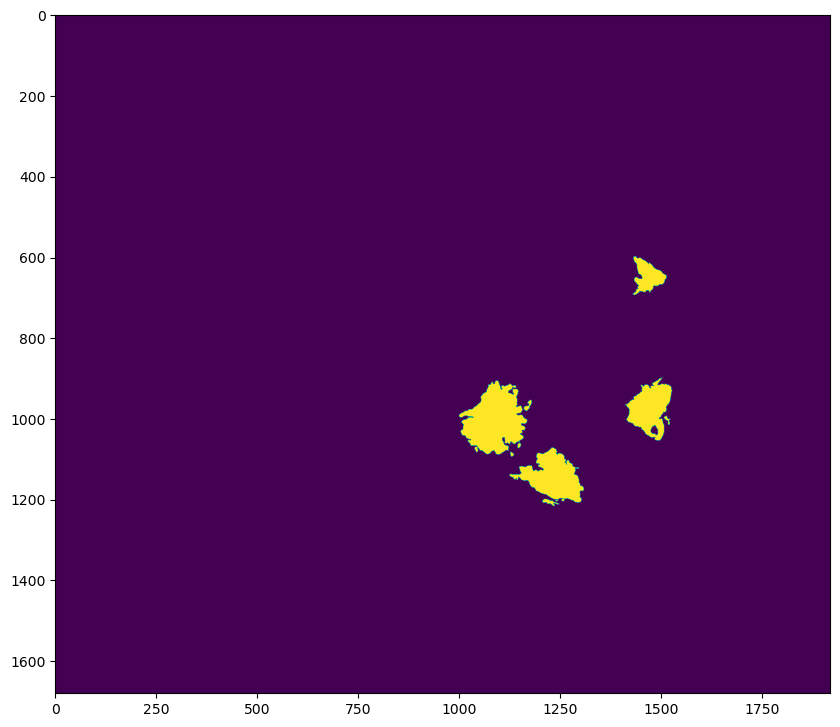

In [26]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

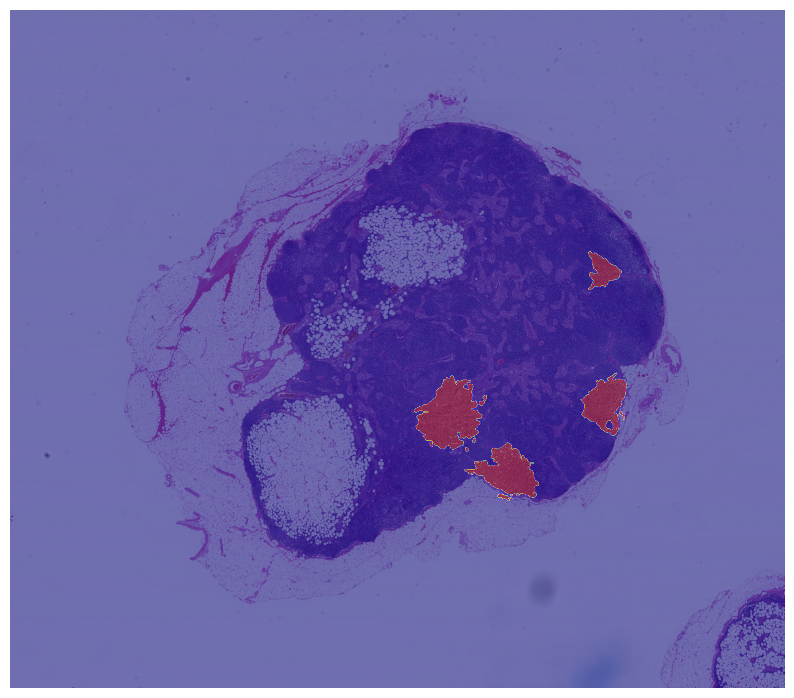

In [29]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.axis('off')
plt.savefig("./figs/CelluleWMask.jpg",bbox_inches='tight')

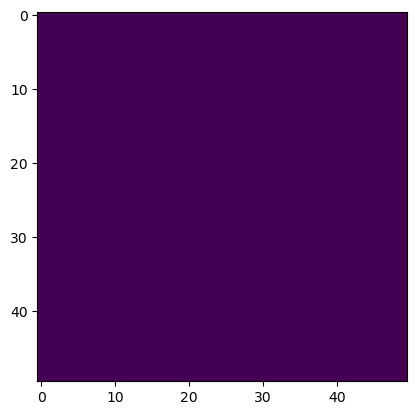

In [11]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

3309752 tissue_pixels pixels (1.8 percent of the image)


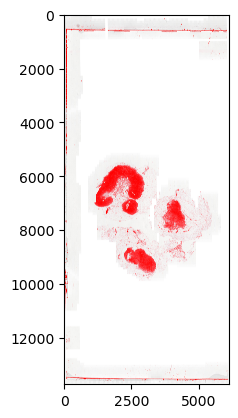

In [18]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [37]:
class CustomArgParse():
    def __init__(
        self,
        number_of_zooms=[0,1,3],
        window_size = 299,
        stride = 32,
        level = 3,
        gray_threshold = 0.8,
        pixel_threshold = 0.2
        ):
        self.number_of_zooms = number_of_zooms
        self.window_size = window_size
        self.stride = stride
        self.level = level
        self.gray_threshold = 0.8
        self.pixel_threshold = 0.2

In [ ]:
import logging
from importlib import reload
reload(logging)
from doc.core.sliding_window import build_training_patches
from doc.core.utils import custom_logger

logger = custom_logger()
args = CustomArgParse(level=5)
with open("./data/patches_tumor_label.csv","w") as file:
    build_training_patches(logger,slide_name,tumor_mask_name,args,file)

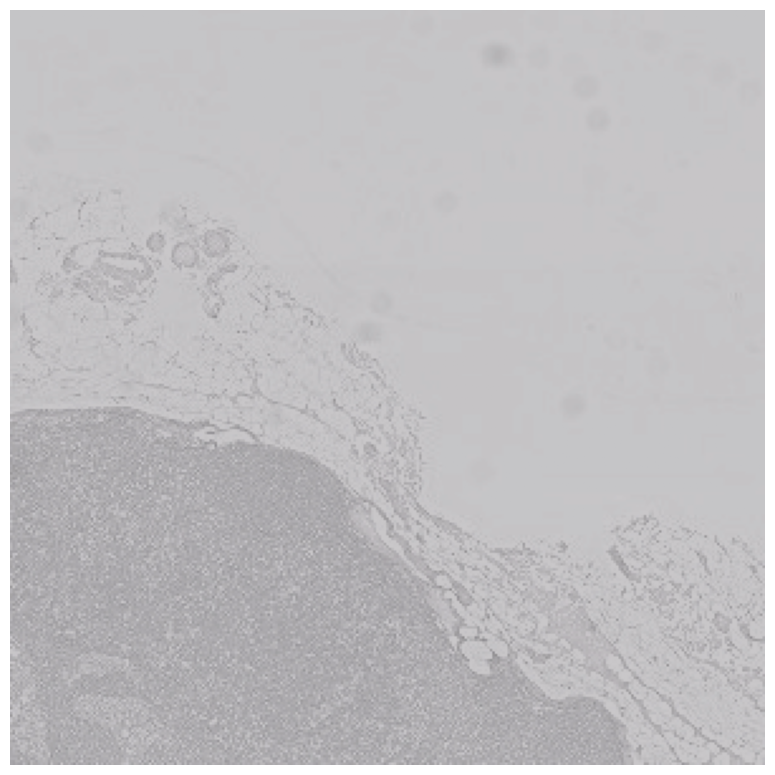

In [57]:
from doc.core.model import DataAugLayer
import tensorflow as tf

img = tf.io.read_file("./data/patches/zoom_x1/tumor_091_510.jpg")
img = tf.image.decode_jpeg(img, channels=3)
augmentation_data = DataAugLayer()(img)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(augmentation_data)
plt.axis("off")
plt.savefig("./figs/Augmented_Data.jpg",bbox_inches="tight")